# Step 1: HQNO FACS to Microscopy Calibration

This notebook creates a calibration curve to convert FACS fluorescence measurements to microscopy-equivalent values for HQNO experiments.

**What this code does:**
1. Loads FACS and microscopy calibration data for different HQNO concentrations
2. Computes median GFP intensities for each concentration and replicate
3. Fits linear relationships between FACS and microscopy measurements using:
   - Ordinary Least Squares (OLS) regression
   - Orthogonal Distance Regression (ODR) to account for errors in both measurements
4. Creates a comparison plot showing both fitting methods
5. Applies the ODR-derived conversion function to transform FACS data to microscopy equivalents
6. Saves the transformed data for downstream analysis
7. Creates supplementary figure showing calibration curve


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.odr import Model, RealData, ODR
from pathlib import Path

# ——— Configuration ———
FACS_CSV    = Path.cwd().parent / 'datafiles' / 'hqno_calibration_facs.csv'
MICRO_CSV   = Path.cwd().parent / 'datafiles' / 'hqno_calibration_microscopy.csv'

OUTPUT_CSV = Path.cwd() / 'data' / '1_hqno_facs_transformed.csv'

HQNO_ORDER  = [
    'HQNO_0','HQNO_5','HQNO_10','HQNO_20','HQNO_40','HQNO_80',
    'HQNO_160','HQNO_320','HQNO_640','HQNO_1280','HQNO_2500','HQNO_5000'
]
COMPARE_LEVELS = ['HQNO_40','HQNO_80','HQNO_160','HQNO_320','HQNO_2500'] # levels to include in the fit (low levels excluded as they are below detection limit of FACS)

# ——— Helper functions ———
def linear_model(B, x):
    return B[0]*x + B[1]

# ——— Data loading & processing ———
def load_data():
    facs = pd.read_csv(FACS_CSV)
    facs['HQNO'] = pd.Categorical(facs['HQNO'], categories=HQNO_ORDER, ordered=True)

    micro = pd.read_csv(MICRO_CSV)
    micro['HQNO'] = (micro['HQNO']
                     .str.replace('_ng','', regex=False)
                     .astype(pd.CategoricalDtype(HQNO_ORDER, ordered=True)))
    return facs, micro

def compute_microscopy_medians(micro: pd.DataFrame) -> pd.DataFrame:
    """
    Compute median intensity_raw_gfp per HQNO & pos for *all* HQNO levels present.
    """
    df = (
        micro
        .groupby(['HQNO','pos'], observed=True)['intensity_raw_gfp']
        .median()
        .reset_index(name='median_gfp')
        .rename(columns={'pos':'replicate'})
    )
    return df

def merge_and_summarize(facs: pd.DataFrame, micro_med: pd.DataFrame) -> pd.DataFrame:
    """
    Merge FACS & microscopy medians and compute 25/75% errors for *all* HQNO.
    """
    merged = pd.merge(micro_med, facs, on='HQNO', suffixes=('_micro','_facs'))
    agg = (
        merged
        .groupby('HQNO', observed=True)
        .agg(
            median_x=('median_gfp_micro','median'),
            p25_x   =('median_gfp_micro', lambda s: np.percentile(s,25)),
            p75_x   =('median_gfp_micro', lambda s: np.percentile(s,75)),
            median_y=('median_gfp_facs','median'),
            p25_y   =('median_gfp_facs', lambda s: np.percentile(s,25)),
            p75_y   =('median_gfp_facs', lambda s: np.percentile(s,75)),
        )
        .reset_index()
    )
    agg['x_err_low']  = agg['median_x'] - agg['p25_x']
    agg['x_err_high'] = agg['p75_x'] - agg['median_x']
    agg['y_err_low']  = agg['median_y'] - agg['p25_y']
    agg['y_err_high'] = agg['p75_y'] - agg['median_y']
    return agg

# ——— Fitting routines ———
def fit_ols(df: pd.DataFrame):
    x, y = df['median_x'].values, df['median_y'].values
    slope, intercept = np.polyfit(x, y, 1)
    x_vals = np.linspace(x.min(), x.max(), 100)
    return slope, intercept, x_vals, slope*x_vals + intercept

def fit_odr(df: pd.DataFrame, slope0: float, intercept0: float):
    x = df['median_x'].values
    y = df['median_y'].values
    sx = (df['x_err_low'] + df['x_err_high'])/2
    sy = (df['y_err_low'] + df['y_err_high'])/2

    data = RealData(x, y, sx=sx.values, sy=sy.values)
    model = Model(linear_model)
    odr = ODR(data, model, beta0=[slope0, intercept0])
    out = odr.run()
    m_odr, b_odr = out.beta
    x_vals = np.linspace(x.min(), x.max(), 100)
    return m_odr, b_odr, x_vals, m_odr*x_vals + b_odr

def plot_comparison(agg: pd.DataFrame, figsize=(6,6), title=None, plot_odr=True, plot_ols=True, label_offset=(50,-50), label_align=('left','top')):
    # separate fit vs excluded
    fit_df   = agg[agg['HQNO'].isin(COMPARE_LEVELS)]
    other_df = agg[~agg['HQNO'].isin(COMPARE_LEVELS)]

    # get two fits on the fit_df
    m1, b1, x1, y1 = fit_ols(fit_df)
    m2, b2, x2, y2 = fit_odr(fit_df, m1, b1)

    plt.figure(figsize=figsize)
    # excluded points in light gray
    xerr_o = np.vstack([other_df['x_err_low'], other_df['x_err_high']])
    yerr_o = np.vstack([other_df['y_err_low'], other_df['y_err_high']])
    plt.errorbar(
        other_df['median_x'], other_df['median_y'],
        xerr=xerr_o, yerr=yerr_o,
        fmt='o', ecolor='lightgray', color='lightgray',
        capsize=4, label='Excluded'
    )

    # included points in black
    xerr_f = np.vstack([fit_df['x_err_low'], fit_df['x_err_high']])
    yerr_f = np.vstack([fit_df['y_err_low'], fit_df['y_err_high']])
    plt.errorbar(
        fit_df['median_x'], fit_df['median_y'],
        xerr=xerr_f, yerr=yerr_f,
        fmt='o', ecolor='gray', color='black',
        capsize=4, label='Included'
    )

    # regression line
    if plot_ols:
        plt.plot(x1, y1, color='blue', label=f'OLS: y={m1:.2f}x+{b1:.1f}', linestyle='--')
    if plot_odr:
        plt.plot(x2, y2, color='black', linestyle='-', label=f'ODR: y={m2:.2f}x+{b2:.1f}')

    # annotate only the fit points
    for _, row in fit_df.iterrows():
        lbl = row['HQNO'].replace('HQNO_', '')
        plt.text(row['median_x']+label_offset[0], row['median_y']-label_offset[1], lbl,
                 fontsize=9, ha=label_align[0], va=label_align[1])

    plt.xlabel('Median GFP (Microscopy)')
    plt.ylabel('Median GFP (FACS)')
    if title:
        plt.title(title)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    return (plt.gcf(), plt.gca())

def facs_to_micro(gfp_facs, slope, intercept):
    """
    Convert a FACS-measured GFP value into the microscopy-equivalent GFP
    using the ODR fit parameters.
    """
    return (gfp_facs - intercept) / slope


Saved transformed FACS→microscopy data to /Users/simonvanvliet/Library/CloudStorage/Dropbox/Work/Code/Spatial Tolerance Model/1_dose_response_curves/data/1_hqno_facs_transformed.csv


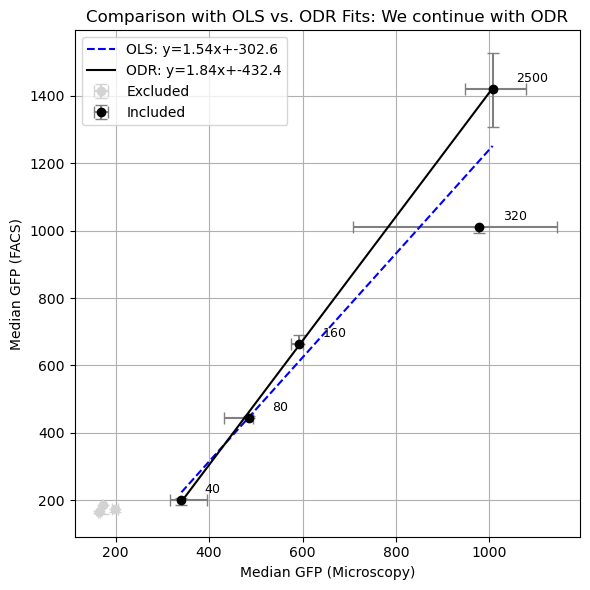

In [2]:
# ——— Main analysis ———
facs_df, micro_df = load_data()
micro_med = compute_microscopy_medians(micro_df)
agg = merge_and_summarize(facs_df, micro_med)
plot_comparison(agg, title='Comparison with OLS vs. ODR Fits: We continue with ODR')
#plt.savefig(Path.cwd() / 'figures' / 'hqno_facs_microscopy_fit.pdf', dpi=300, bbox_inches='tight', transparent=True)

# fit on the levels you care about
fit_df = agg[agg['HQNO'].isin(COMPARE_LEVELS)]
m1, b1, _, _ = fit_ols(fit_df)
m2, b2, _, _ = fit_odr(fit_df, m1, b1)

# apply transformation to FACS data, use ODR parameters
facs_df['predicted_micro_gfp'] = facs_to_micro(facs_df['median_gfp'], slope=m2, intercept=b2)

# save transformed data
facs_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved transformed FACS→microscopy data to {OUTPUT_CSV}")

Plot shows median +/- 25th/75th percentiles for microscopy and FACS data.


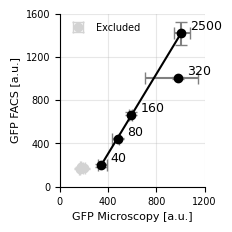

In [3]:
# ——— Figure styling ———
final_width_cm = 6
final_height_cm = 6
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# ——— plot calibration figure ———
fig, ax = plot_comparison(agg, title='',plot_ols=False, figsize=(final_width_in, final_height_in), label_offset=(75,0), label_align=('left','bottom'))

# Turn off legend
ax.legend().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.3)

ax.set_xlim(0, 1200)
ax.set_ylim(0, 1600)
ax.set_xticks(np.arange(0, 1201, 400))
ax.set_yticks(np.arange(0, 1601, 400))

# Set font size for axis labels and ticks
ax.tick_params(labelsize=font_size-1)
ax.set_xlabel('GFP Microscopy [a.u.]', fontsize=font_size)
ax.set_ylabel('GFP FACS [a.u.]', fontsize=font_size)
plt.tight_layout()

# Add legend for excluded points only
legend_elements = [handle for handle, label in zip(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1]) if 'Excluded' in label]
ax.legend(handles=legend_elements, loc='upper left', fontsize=font_size-1, frameon=False)

# Save figure
FIGURE_PATH = Path.cwd() / 'figures' / 'hqno_facs_microscopy_fit.pdf'
plt.savefig(FIGURE_PATH, dpi=300, bbox_inches='tight', transparent=True)

print('Plot shows median +/- 25th/75th percentiles for microscopy and FACS data.')
